In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2023-12-22 22:30:00.805915: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-22 22:30:00.855878: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:


X_train_df = np.load('X_train_log_5Nor.npy')
y_train_df = np.load('y_train_log_5Nor_detrend.npy')

x_test_df = np.load('X_test_log_5Nor.npy')
y_test_df = np.load('y_test_log_5Nor_detrend.npy')


print(X_train_df.shape,y_train_df.shape,x_test_df.shape,y_test_df.shape)

(149068, 5, 8) (149068, 1) (4048, 5, 8) (4048, 1)


In [3]:
X_train = X_train_df
X_test = x_test_df
y_train = y_train_df.reshape((149068, 1, 1))
y_test = y_test_df.reshape((4048, 1, 1))

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(149068, 5, 8) (4048, 5, 8) (149068, 1, 1) (4048, 1, 1)


In [4]:
# 如果数据中包含 NaN 或 Inf，以下代码将返回 True
contains_nan_inf_X = np.isnan(X_train).any() or np.isinf(X_train).any()
contains_nan_inf_y = np.isnan(y_train).any() or np.isinf(y_train).any()

if contains_nan_inf_X or contains_nan_inf_y:
    print("数据中包含 NaN 或 Inf。")
else:
    print("数据中没有 NaN 或 Inf。")
    

# 统计 X_train 中的 NaN 和 Inf 的数量
nan_count_X = np.isnan(X_train).sum()
inf_count_X = np.isinf(X_train).sum()

# 统计 y_train 中的 NaN 和 Inf 的数量
nan_count_y = np.isnan(y_train).sum()
inf_count_y = np.isinf(y_train).sum()

print("X_train 中的 NaN 数量:", nan_count_X)
print("X_train 中的 Inf 数量:", inf_count_X)

print("y_train 中的 NaN 数量:", nan_count_y)
print("y_train 中的 Inf 数量:", inf_count_y)

数据中没有 NaN 或 Inf。
X_train 中的 NaN 数量: 0
X_train 中的 Inf 数量: 0
y_train 中的 NaN 数量: 0
y_train 中的 Inf 数量: 0


In [5]:
# set hyperparameters
n_neuron       = 128
activation     = 'relu'
num_epochs     = 100
learning_rate  = 0.01
minibatch_size = 128
model_num      = 1

In [6]:
lstm_model = Sequential()
lstm_model.add(LSTM(n_neuron,input_shape=(X_train.shape[1],X_train.shape[2]),
               return_sequences=True,activation=activation))
lstm_model.add(LSTM(n_neuron,return_sequences=True,
               activation=activation))
lstm_model.add(LSTM(n_neuron,return_sequences=False,
               activation=activation))
lstm_model.add(Dense(n_neuron,activation=activation))
lstm_model.add(Dense(y_train.shape[-1],activation='linear')) 

lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            70144     
                                                                 
 lstm_1 (LSTM)               (None, 5, 128)            131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 349,953
Trainable params: 349,953
Non-trainable params: 0
_________________________________________________________________


In [7]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = lstm_model.fit(X_train, y_train, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)


Epoch 1/100
932/932 [==============================] - 29s 28ms/step - loss: 0.4390 - val_loss: 0.2648
Epoch 2/100
932/932 [==============================] - 25s 27ms/step - loss: 0.4024 - val_loss: 0.2610
Epoch 3/100
932/932 [==============================] - 25s 27ms/step - loss: 0.7985 - val_loss: 0.2785
Epoch 4/100
932/932 [==============================] - 25s 27ms/step - loss: 0.7758 - val_loss: 0.2993
Epoch 5/100
932/932 [==============================] - 23s 25ms/step - loss: 0.4656 - val_loss: 0.3662
Epoch 6/100
932/932 [==============================] - 23s 25ms/step - loss: 0.4818 - val_loss: 0.2898
Epoch 7/100
932/932 [==============================] - 24s 25ms/step - loss: 0.4576 - val_loss: 0.2893


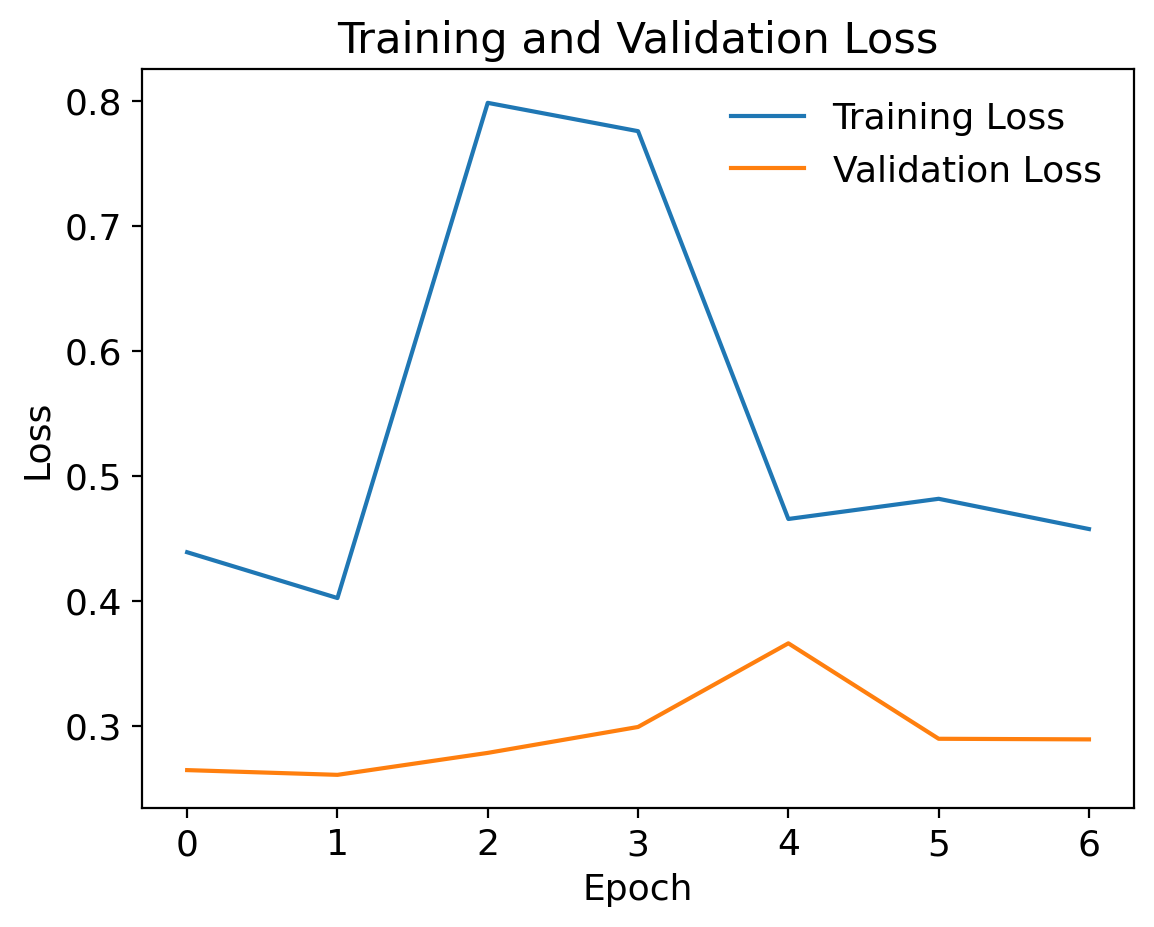

In [8]:
# 绘制损失值曲线
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
# model_path = os.path.join(cwd,'saved_model')
# make_dir(model_path)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
lstm_model.save('LSTM_log_model_5_nor_3L_detrend.h5')

In [63]:
# reload the saved model
lstm_model = load_model('LSTM_log_model_5_nor_3L_detrend.h5')
y_test_pre = lstm_model.predict(X_test)

127/127 [==============================] - 1s 4ms/step


In [64]:
y_test_pre

array([[0.5418293 ],
       [0.88742185],
       [0.6328453 ],
       ...,
       [0.7586404 ],
       [0.7670779 ],
       [0.8900051 ]], dtype=float32)

In [65]:
print(y_test_pre.shape,y_test.shape)

(4048, 1) (4048, 1, 1)


In [66]:
np.save('y_test_pre_5_Nor_3L_detrend.npy', y_test_pre)

In [2]:
#add disturbance to test data
Test_Set_disturbe_Pr = np.load('Test_Set_disturbe_Pr.npy')
Test_Set_disturbe_Temp = np.load('Test_Set_disturbe_Temp.npy')

Test_Set_disturbe_Irri = np.load('Test_Set_disturbe_Irri.npy')
Test_Set_disturbe_Fert = np.load('Test_Set_disturbe_Fert.npy')

Test_Set_disturbe_OM = np.load('Test_Set_disturbe_Pr.npy')
Test_Set_disturbe_Sand = np.load('Test_Set_disturbe_Sand.npy')
Test_Set_disturbe_Clay = np.load('Test_Set_disturbe_Clay.npy')
Test_Set_disturbe_Silt = np.load('Test_Set_disturbe_Silt.npy')


In [10]:
lstm_model = load_model('LSTM_log_model_5_nor_3L.h5')
y_test_pre = lstm_model.predict(Test_Set_disturbe_Silt)
np.save('Predict_disturbe_Silt.npy', y_test_pre)

127/127 [==============================] - 1s 4ms/step
